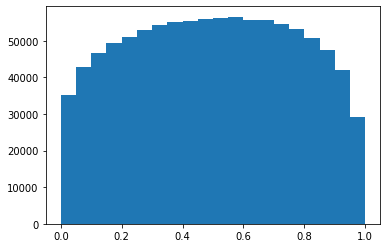

In [67]:
# PPC Distribution Test

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

normal_dist = lambda x, m, s: 1 / (np.sqrt(2*np.pi) * s) * np.exp(-1/2 * ((x - m) / s)**2)

s1 = 5
s2 = 10
b = 20

true_counts = np.array([s1, s2, b, b])

# Normal Distributions, True Source Known, Background is Average
num_samples = 1000000
measured_counts = np.random.normal(true_counts, np.sqrt(true_counts), (num_samples, len(true_counts)))
b_max_L = b + np.average(measured_counts - true_counts[np.newaxis,:], axis=1)
std_b = np.sqrt(np.sum(true_counts) / len(true_counts)**2)

# n, bins, _ = plt.hist(b_max_L, bins=50)
# xs = np.linspace(b-3*std_b, b+3*std_b, 100)
# ys = normal_dist(xs, b, std_b)
# plt.plot(xs, ys*np.amax(n)/np.amax(ys))
# plt.title("b_max_L")

available_data = np.zeros((num_samples, 4))
available_data[:,:2] = np.repeat(true_counts[:2][np.newaxis,:], num_samples, axis=0)
available_data[:,2:] = np.repeat(b_max_L[:,np.newaxis], 2, axis=1)

expected_mean_variance = np.sum(available_data, axis=1) / available_data.shape[1]**2
expected_std = np.sqrt((2*expected_mean_variance[:,np.newaxis] + available_data) / 2)

expected_counts = available_data[:,:2] + available_data[:,2:]
expected_counts_std = np.sqrt(available_data[:,:2] + expected_std[:,2:]**2)
# expected_counts_std = np.sqrt(available_data[:,:2] + available_data[:,2:]**2)


counts = measured_counts[:,:2] + measured_counts[:,2:]

cdf = norm.cdf(counts, expected_counts, expected_counts_std)
_ = plt.hist(cdf[:,1], bins=20)

In [5]:
# convert scw.list into pointing array

import numpy as np
import astropy.io.fits as fits
from astropy.table import Table
import astropy.time as at
from datetime import datetime
from PointingClusters import save_clusters
from IntegralPointingClustering import ClusteredQuery


with open("scw.list","r") as scw_file:
    scws = []
    with fits.open("crab_data/1667/pointing.fits") as file:
        tab = Table.read(file[1])
        for line in scw_file:
            scw = line[9:21]
            pointing_fits_info = tab[tab["PTID_ISOC"]==scw[:8]]
            t = at.Time(f'{pointing_fits_info["TSTART"][0]+2451544.5}', format='jd').iso[:-4]
            y, m, d, h, mi, s = int(t[:4]), int(t[5:7]), int(t[8:10]), int(t[11:13]), int(t[14:16]), int(t[17:19])
            tstart = datetime(y, m, d, h, mi, s)
            rax, decx= pointing_fits_info["RA_SPIX", "DEC_SPIX"].as_array()[0]
            
            scws.append(np.array([scw, rax, decx, tstart]))
            
    scws = np.array(scws)
    
cq = ClusteredQuery(
    scws,
    angle_weight=0.,
    time_weight=5.,
    max_distance=1.,
    min_ang_distance=1.5,
    max_ang_distance=7.5,
    cluster_size_range = (2,2),
    failed_improvements_max=3,
    suboptimal_cluster_size=1,
    close_suboptimal_cluster_size=1
).get_clustered_scw_ids()

pointings = []
for size in range(2, 3):
    for cluster in cq[size]:
        pointings.append(tuple([(i, f"crab_data/{i[:4]}") for i in cluster]))
pointings = tuple(pointings)

folder = "orbit_1667_spimodfit_scws"

save_clusters(pointings, folder)


In [2]:
# quartic root

import matplotlib.pyplot as plt
import math
import numpy as np

def quartic_root(A, B, C, D, E):
    alpha = -3 * B**2 / (8 * A**2) + C/A
    beta = B**3 / (8 * A**3) - B * C / (2 * A**2) + D/A
    gamma = -3 * B**4 / (256 * A**4) + C * B**2 / (16 * A**3) - B * D / (4 * A**2) + E / A
    
    if beta == 0.:
        s1 = (alpha**2 - 4*gamma)**0.5
        s2 = ((-alpha + s1) / 2)**0.5
        x = -B/(4*A) + s2
        return x
    
    P = -(alpha**2)/12 - gamma
    Q = -(alpha**3)/108 + alpha*gamma/3 - (beta**2) / 8
    R = -Q/2 + (Q**2 / 4 + P**3 / 27)**0.5
    U = R**(1/3)
    if U == 0.:
        y = -5/6*alpha - (Q**(1/3))
    else:
        y = -5/6*alpha + U - P/(3*U)
    W = (alpha + 2*y)**0.5
    
    s1 = 2*beta/W
    s2 = (-(3*alpha + 2*y + s1))**0.5
    s3 = (W + s2) / 2
    x = -B / (4*A) + s3
    return x

In [12]:
quartic_root(-20.144230141415672, -10.332401583717097, 749.272358187044, 2301.1616043142335, 1578.436366036694)

(7.145137971906084-1.6766410874710565e-18j)

In [17]:
def b_maxL_4(m, t, C):
    t_t = np.sum(t)
    C_ = np.zeros(4)
    m_plus = np.zeros(4)
    m_cross = np.zeros(4)
    m_dot = np.zeros(4)
    
    for i in range(4):
        C_[i] = C[i] - t[i] * m[i]
        m_plus[i] = m[(i+1) % 4] + m[(i+2) % 4] + m[(i+3) % 4]
        m_cross[i] = (m[(i+1) % 4] * m[(i+2) % 4]
                      + m[(i+2) % 4] * m[(i+3) % 4]
                      + m[(i+3) % 4] * m[(i+1) % 4])
        m_dot[i] = m[(i+1) % 4] * m[(i+2) % 4] * m[(i+3) % 4]
        
    A = -t_t.item()
    B = np.sum(C_ - t * m_plus).item()
    C = np.sum(C_ * m_plus - t * m_cross).item()
    D = np.sum(C_ * m_cross - t * m_dot).item()
    E = np.sum(C_ * m_dot).item()
    
    # print(A,B,C,D,E)
    
    alpha = -3 * B**2 / (8 * A**2) + C/A
    beta = B**3 / (8 * A**3) - B * C / (2 * A**2) + D/A
    gamma = -3 * B**4 / (256 * A**4) + C * B**2 / (16 * A**3) - B * D / (4 * A**2) + E / A
    
    if beta == 0.:
        s1 = (alpha**2 - 4*gamma)**0.5
        s2 = ((-alpha + s1) / 2)**0.5
        x = -B/(4*A) + s2
        return x
    
    P = -(alpha**2)/12 - gamma
    Q = -(alpha**3)/108 + alpha*gamma/3 - (beta**2) / 8
    R = -Q/2 + (Q**2 / 4 + P**3 / 27)**0.5
    U = R**(1/3)
    if U == 0.:
        y = -5/6*alpha - (Q**(1/3))
    else:
        y = -5/6*alpha + U - P/(3*U)
    W = (alpha + 2*y)**0.5
    
    s1 = 2*beta/W
    s2 = (-(3*alpha + 2*y + s1))**0.5
    s3 = (W + s2) / 2
    x = -B / (4*A) + s3
    return x.real
    

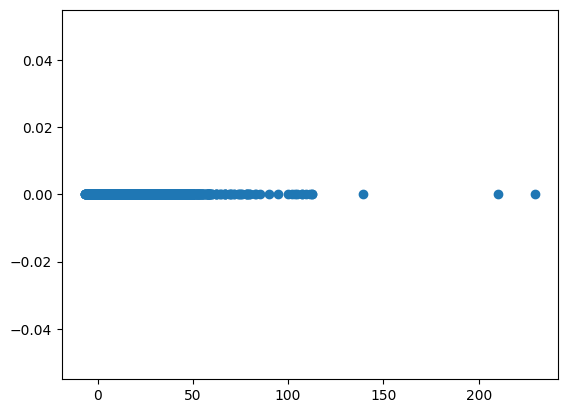

In [18]:
# b_maxl_4 tester
res = []

for i in range(100000):
    m = np.random.random(4) * 10
    t = np.random.random(4) * 10
    C = np.random.random(4) * 100
    
    res.append(b_maxL_4(m, t, C))
    
plt.scatter([i.real for i in res], [i.imag for i in res])

-0.002419432406213673 328.4167336591813 30.581394336596986 92.33436282645096 370.06679559099564 135741.32433394087 -4.97781741087249
-0.0006417204079411931 240.36756980397183 -297.6800538266573 -228.0812799130336 81.0339501403796 (374566.20063040097+8.21100664341263e-27j) (2102.0038811617123-2.7690230815135403e-13j)
-0.004201386158740661 -372.8498086483811 -144.53879866595253 -201.13093884564103 -19.86373154500967 (-0.1452607999126485+0.7000881309888265j) (-1.3491680326185254-0.00014285282406945043j)
0.008645912093015795 -438.5045411596967 -96.37837600535516 -228.02232193731908 -460.6160536213556 50718.35531022401 -3.350407662872385
0.0001258145736642291 -368.67328741445925 292.8827294132702 -109.78312368111034 135.16703983169964 2930290.003193867 3236.82488634211
33.96298316434297 69.56653122525506 -191.93309800250103 -234.2033070878755 -210.33239468290134 (1.389894873088009-0.027421174940243716j) (-593.4653616177065+6.217248937900877e-15j)
-54.82293796481099 42.51828012353826 443.623

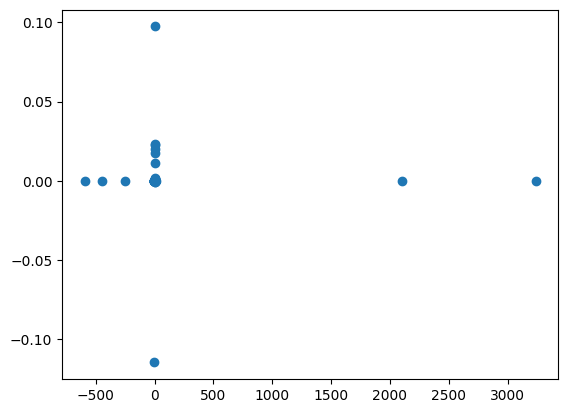

In [3]:
# quartic root tester

res = []
for i in range(1000000):
    arg = np.random.random(5)*1000-500
    A = float(arg[0])
    B = float(arg[1])
    C = float(arg[2])
    D = float(arg[3])
    E = float(arg[4])
    x = quartic_root(A, B, C, D, E)

            
    res.append(
        (A*x**4 + B*x**3 + C*x**2 + D*x + E)
    )
    if abs(res[-1]) > 1.:
        print(A, B, C, D, E, x, res[-1])
plt.scatter([i.real for i in res], [i.imag for i in res])

In [ ]:
# number of scws in crab FOV per revolulution

from IntegralQuery import SearchQuery, IntegralQuery, Filter, Range
from astropy.coordinates import SkyCoord

p = SkyCoord(83.6333, 22.0144, frame="icrs", unit="deg")
searchquerry = SearchQuery(position=p, radius="5 degree",)
cat = IntegralQuery(searchquerry)
f = Filter(SCW_TYPE="POINTING")
scw_ids_all = cat.apply_filter_on_revolutions(f)
for orbit, count in scw_ids_all.items():
    print(orbit, count)

In [ ]:
# create fits file with only some rows

from astropy.io import fits
t = fits.open('sec_source_test.fits.gz')
tbdata = t[1].data
mask = [False for i in range(len(tbdata))]
mask[0] = True
mask[1] = True
newtbdata = tbdata[mask]
hdu = fits.BinTableHDU(data=newtbdata, name="SPI.-SRCL-CAT")
hdu.writeto('new_sec_source_test.fits.gz')